# Model 2 - Convolutional neural network (CNN) using only geo-spatial features

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.append('./src')
from data_utils import *
clear_output(wait=False)

### Load train, validation and test data

In [2]:
user_train, user_val, user_test = train, val, test = train_test_data_split()

In [3]:
data_train = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_train]).reset_index(drop=True)
data_val = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_val]).reset_index(drop=True)
data_test = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_test]).reset_index(drop=True)

Segmentation is not strictly needed for the CNN-only model, but in order to ensure the datesets accross all three models are the same we still perform it here, and purge all points that would otherwise been purged to build the sequences.

In [4]:
data_train = data_train[data_train['segment_ix'] >= 5]
data_val = data_val[data_val['segment_ix'] >= 5]
data_test = data_test[data_test['segment_ix'] >= 5]

#### Example input data

Here we only use the ``user`` and ``image_ix`` to lookup the precomputed image frame and time of day ``tod`` as input, output is the ``label``, where *0 = motion*, and *1 = stop*:

In [5]:
data_train[['user', 'image_ix', 'tod', 'label']].head(5)

,user,image_ix,tod,label
15,8,603,1,1
16,8,604,1,1
17,8,605,1,1
18,8,606,1,1
19,8,607,1,1


### Load precomputed image frames

In [6]:
image_data = {}
for user_id in user_train + user_val + user_test:
    with open(f'/mnt/array/valse_data/DeepLearning/Project/Pickle/images_list_{user_id}.pickle', 'rb') as f:
        image_data[user_id] = np.stack(pickle.load(f), axis = 0).astype(float)

#### Example GIS image data

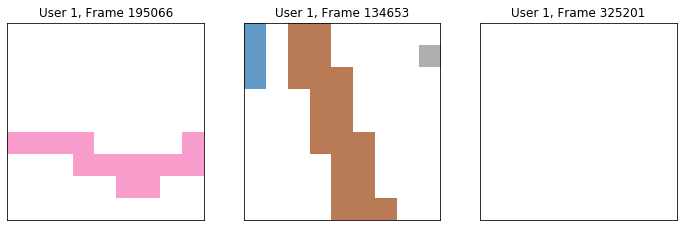

In [7]:
from bokeh.palettes import Set1_9 
image_sample_ix = data_train[lambda x: (x['label'] == 0) & (x['delta_t'] <= 1)].sample(3, random_state = 42)[['user', 'image_ix']].values
fig, ax = plt.subplots(figsize = (3*4, 4), ncols = 3)
for j, (user_id, image_ix) in enumerate(image_sample_ix):
    ax[j].set_title(f'User {user_id}, Frame {image_ix}')
    for i, feature_ix in enumerate([4, 5, 3, 6, 7, 8, 10, 0, 2]):
        feature = image_data[user_id][image_ix][:,:,feature_ix]
        color = list(hex_to_rgb(Set1_9[i]))
        color.append(200)
        layer = np.stack([(feature >= 1) * c / 255. for c in color], axis = 2)
        ax[j].imshow(layer, origin = 'lower')
        ax[j].tick_params(
            axis='both',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
plt.savefig("context_frame.svg", bbox_inches='tight')

#### Numer of training data points

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Define Image Tensor Dataset

We implement our own Tensor Dataset in order to be able to do fast lookup of images.

In [9]:
class ImageTensorDataset(torch.utils.data.Dataset):

    def __init__(self, df, image_data):
        self.labels = df['label'].values
        self.tod = df['tod'].values
        self.user_id = df['user'].values
        self.image_ix = df['image_ix'].values        
        self.image_data = image_data
        self.tod_one_hot = np.eye(6)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, key):
        image = self.image_data[self.user_id[key]][self.image_ix[key]]
        tod_one_hot = self.tod_one_hot[self.tod[key]]
        return image, tod_one_hot, self.labels[key]   

## Example Input/output data from ``TensorDataset``

In [10]:
demo_dataset = ImageTensorDataset(data_train.head(3), image_data)

for X_img, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=3, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])

X_img : torch.Size([3, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
X_tod : torch.Size([3, 6])
tensor([0., 1., 0., 0., 0., 0.], dtype=torch.float64)
y : torch.Size([3])
tensor(1)


### Hyper Parameters

In [11]:
IMG_INPUT_H_W = 9, 9
IMG_INPUT_C = 11
TOD_INPUT_DIM = 6
CNN_HIDDEN_DIM = 32
CNN_HIDDEN_DIM_2 = 16
CNN_KERNEL_SIZE = 3
CNN_PADDING = 1
FC_HIDDEN_DIM = 16
NUM_CLASSES = 2

DROPOUT_PROP = .2

NUM_EPOCH = 25
BATCH_SIZE = 12000
LEARNING_RATE = 0.1
LEARNING_DECAY_FACTOR = 0.1
LEARNING_DECAY_EPOCHS = [15,20]

#### Define Data Loaders

In [12]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=True)

#### Define some utility functions for building and running the network

In [13]:
def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def conv2d_output_shape(h_w, kernel_size=1, stride=1, padding=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * padding) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * padding) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

### Define network for Convolutional neural network (CNN) using only geo-spatial features

In [14]:
class CnnNet(nn.Module):

    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(IMG_INPUT_C, CNN_HIDDEN_DIM, kernel_size=CNN_KERNEL_SIZE, padding=CNN_PADDING),
            nn.BatchNorm2d(CNN_HIDDEN_DIM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(DROPOUT_PROP)
        )
        
        h, w = IMG_INPUT_H_W
        #print(h, w)
        h, w = conv2d_output_shape((h, w), CNN_KERNEL_SIZE, padding=CNN_PADDING)
        #print(h, w)
        h, w = conv2d_output_shape((h, w), kernel_size=3, stride=2, padding=0)        
        #print(h, w)
        self.layer2 = nn.Sequential(
            nn.Conv2d(CNN_HIDDEN_DIM, CNN_HIDDEN_DIM_2, kernel_size=CNN_KERNEL_SIZE, padding=CNN_PADDING),
            nn.BatchNorm2d(CNN_HIDDEN_DIM_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(DROPOUT_PROP)
        )
        
        h, w = conv2d_output_shape((h, w), CNN_KERNEL_SIZE, padding=CNN_PADDING)
        #print(h, w)
        h, w = conv2d_output_shape((h, w), kernel_size=2, stride=2, padding=0)
        #print(h, w)
        
        self.fc1 = nn.Linear(CNN_HIDDEN_DIM_2 * h * w + TOD_INPUT_DIM, FC_HIDDEN_DIM)
        self.fc2 = nn.Linear(FC_HIDDEN_DIM, NUM_CLASSES)        

    def forward(self, X_img, X_tod):
        X_img = X_img.permute(0, 3, 1, 2)
        out = self.layer1(X_img)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        #print(X_tod.shape)
        out = torch.cat([out, X_tod], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = F.softmax(out, dim=1)
        return out

#### Define class weights due to large class im-balance

In [15]:
class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
class_weights

[1.0, 0.36320774032021247]

#### Define model, optimizer and loss

In [16]:
device = torch.device('cuda:1') # PyTorch v0.4.0
model = CnnNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))

#### Number of parameters

In [17]:
np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

9090

#### Test input/output of model

In [18]:
out = model(X_img.to(device, dtype=torch.float), X_tod.to(device, dtype=torch.float))
print(out.shape)

torch.Size([3, 2])


In [19]:
out[:2].cpu()

tensor([[0.5265, 0.4735],
        [0.5265, 0.4735]], grad_fn=<CopyBackwards>)

In [20]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    },
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

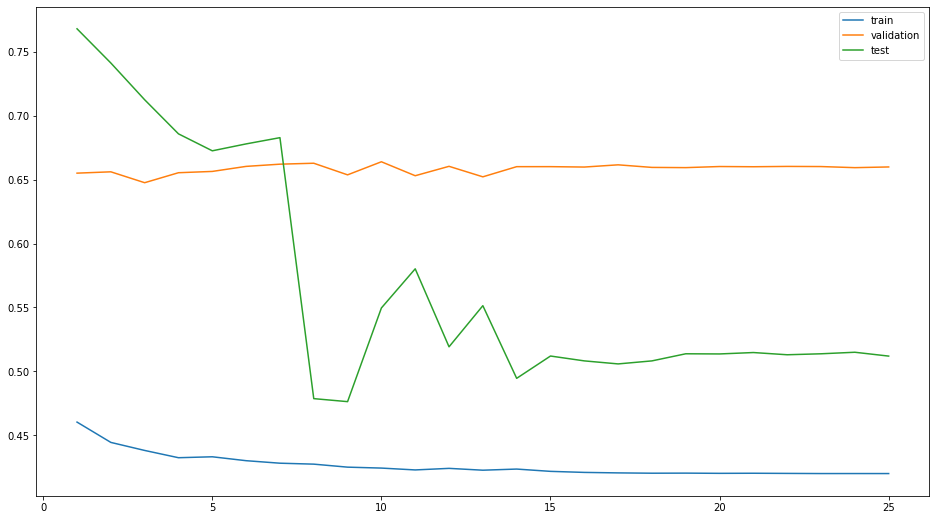

average epoch duration 27.996273393630982
stdev epoch duration 2.2085213778867323
Training lasted 699.9068348407745


In [21]:
epochComputationTime =  []
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            startEpoch = time.time()
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            #print(i)
            X_seq, X_tod, y = batch
            

            X_seq = X_seq.to(device, dtype=torch.float)
            X_tod = X_tod.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.int64)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.5)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        
        if phase_is_training:
            endEpoch = time.time()
            epochComputationTime.append(endEpoch-startEpoch)
            
            
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();
    print(f'average epoch duration {np.mean(epochComputationTime)}')
    print(f'stdev epoch duration {np.std(epochComputationTime)}')
    print(f'Training lasted {np.sum(epochComputationTime)}')

### Validation/Test prediction loop

In [22]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.to(device, dtype=torch.float)
        X_tod = X_tod.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

### Final results

In [23]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop']))

validation
              precision    recall  f1-score   support

      Motion       0.41      0.91      0.57     43324
        Stop       0.81      0.23      0.36     72617

    accuracy                           0.48    115941
   macro avg       0.61      0.57      0.46    115941
weighted avg       0.66      0.48      0.44    115941

test
              precision    recall  f1-score   support

      Motion       0.53      0.87      0.66     42471
        Stop       0.95      0.74      0.83    126024

    accuracy                           0.77    168495
   macro avg       0.74      0.81      0.74    168495
weighted avg       0.84      0.77      0.79    168495

